# Transmittance Spectrum of a Waveguide Bend

We have computed the field patterns for light propagating around a waveguide bend. While this can be visually informative, the results are not quantitatively satisfying. We'd like to know exactly how much power makes it around the bend (transmittance), how much is reflected (reflectance), and how much is radiated away (scattered loss). How can we do this?

The basic principles are described in Introduction. The computation involves keeping track of the fields and their Fourier transform in a certain region, and from this computing the flux of electromagnetic energy as a function of $\omega$. Moreover, we'll get an entire spectrum of the transmittance in a single run, by Fourier-transforming the response to a short pulse. However, in order to normalize the transmitted flux by the incident power to obtain the transmittance, we'll have to do _two_ runs, one with and one without the bend (i.e., a straight waveguide).

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 10 # pixels/um

sx = 16  # size of cell in X direction
sy = 32  # size of cell in Y direction
cell = mp.Vector3(sx,sy,0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

Using MPI version 3.1, 1 processes


We'll also define a couple of parameters to set the width of the waveguide and the "padding" between it and the edge of the cell:

In [2]:
pad = 4  # padding distance between waveguide and cell edge
w = 1    # width of waveguide

In order to define the waveguide positions, we will have to use arithmetic to define the horizontal and vertical waveguide centers as:

In [3]:
wvg_xcen =  0.5*(sx-w-2*pad)  # x center of horiz. wvg
wvg_ycen = -0.5*(sy-w-2*pad)  # y center of vert. wvg

We proceed to define the geometry. We have to do two simulations with different geometries: the bend, and also a straight waveguide for normalization. We will first set up the straight waveguide.

In [4]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,w,mp.inf),
                     center=mp.Vector3(0,wvg_ycen,0),
                     material=mp.Medium(epsilon=12))]

The source is a `GaussianSource` instead of a `ContinuousSrc`, parameterized by a center frequency and a frequency width (the width of the Gaussian spectrum).

In [5]:
fcen = 0.15  # pulse center frequency
df = 0.1     # pulse width (in frequency)
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(-0.5*sx+dpml,wvg_ycen,0),
                     size=mp.Vector3(0,w,0))]

Notice how we're using our parameters like `wvg_ycen` and `w`: if we change the dimensions, everything will shift automatically.

Finally, we have to specify where we want Meep to compute the flux spectra, and at what frequencies. This must be done after specifying the `Simulation` object which contains the geometry, sources, resolution, etcetera, because all of the field parameters are initialized when flux planes are created. As described in Introduction, the flux is the integral of the Poynting vector over the specified `FluxRegion`. It only integrates one component of the Poynting vector and the `direction` property specifies which component. In this example, since the `FluxRegion` is a line, the `direction` is its normal by default which therefore does not need to be explicitly defined.

-----------
Initializing structure...
     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


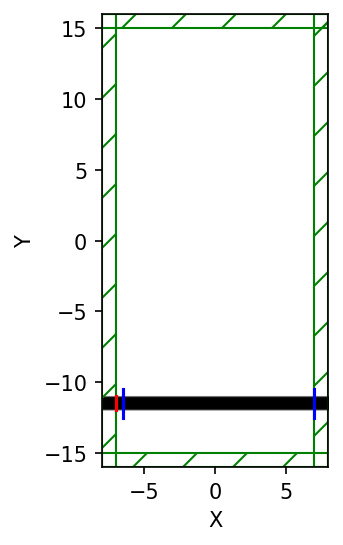

In [6]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5*sx+dpml+0.5,wvg_ycen,0), size=mp.Vector3(0,2*w,0))                            
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5*sx-dpml,wvg_ycen,0), size=mp.Vector3(0,2*w,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

plt.figure(dpi=150)
sim.plot2D()
plt.show()


We compute the fluxes through a line segment twice the width of the waveguide, located at the beginning or end of the waveguide. Note that the flux lines are separated by length dpml from the boundary of the cell, so that they do not lie within the absorbing PML regions. Again, there are two cases: the transmitted flux is either computed at the right or the bottom of the cell, depending on whether the waveguide is straight or bent.

The fluxes will be computed for nfreq=100 frequencies centered on fcen, from fcen-df/2 to fcen+df/2. That is, we only compute fluxes for frequencies within our pulse bandwidth. This is important because, far outside the pulse bandwidth, the spectral power is so low that numerical errors make the computed fluxes useless.

As described in Introduction, computing the reflection spectra requires some care because we need to separate the incident and reflected fields. We do this by first saving the Fourier-transformed fields from the normalization run. And then, before we start the second run, we load these fields, negated. The latter subtracts the Fourier-transformed incident fields from the Fourier transforms of the scattered fields. Logically, we might subtract these after the run, but it turns out to be more convenient to subtract the incident fields first and then accumulate the Fourier transform. All of this is accomplished with two commands which use the raw simulation data: get_flux_data and load_minus_flux_data. We run the first simulation as follows:

In [7]:
pt = mp.Vector3(0.5*sx-dpml-0.5,wvg_ycen)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

field decay(t = 50.050000000000004): 4.825189380557789e-09 / 4.825189380557789e-09 = 1.0
field decay(t = 100.05000000000001): 0.02880180987942578 / 0.02880180987942578 = 1.0
field decay(t = 150.1): 0.0268934650933857 / 0.02880180987942578 = 0.9337421921042788
field decay(t = 200.15): 2.3158397338096397e-13 / 0.02880180987942578 = 8.040604890819488e-12
run 0 finished at t = 200.15 (4003 timesteps)


We need to keep running after the source has turned off because we must give the pulse time to propagate completely across the cell. Moreover, the time required is a bit tricky to predict when you have complex structures, because there might be resonant phenomena that allow the source to bounce around for a long time. Therefore, it is convenient to specify the run time in a different way: instead of using a fixed time, we require that |Ez|2 at the end of the waveguide must have decayed by a given amount (1/1000) from its peak value.

The stop_when_fields_decayed routine takes four arguments: dT, component, pt, and decay_by. What it does is, after the sources have turned off, it keeps running for an additional dT time units every time the given |component|2 at the given point has not decayed by at least decay_by from its peak value for all times within the previous dT. In this case, dT=50, the component is Ez, the point is at the center of the flux plane at the end of the waveguide, and decay_by=0.001. So, it keeps running for an additional 50 time units until the square amplitude has decayed by 1/1000 from its peak. This should be sufficient to ensure that the Fourier transforms have converged.

Finally, we save the incident flux using get_fluxes which will be used later to compute the reflectance and the transmittance:

In [8]:
# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

We need to run the second simulation which involves the waveguide bend. We reset the structure and fields using reset_meep() and redefine the geometry, Simulation, and flux objects. At the end of the simulation, we save the reflected and transmitted fluxes.

-----------
Initializing structure...
     block, center = (-2,-11.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (3.5,2,0)
          size (1,28,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
field decay(t = 50.050000000000004): 1.697652269444903e-10 / 1.697652269444903e-10 = 1.0
field decay(t = 100.05000000000001): 4.6910710639105265e-07 / 4.6910710639105265e-07 = 1.0
field decay(t = 150.1): 2.992872733686264e-07 / 4.6910710639105265e-07 = 0.6379934758846679
field decay(t = 200.15): 0.0039278135652722765 / 0.0039278135652722765 = 1.0
field decay(t = 250.20000000000002): 0.00015009081939073738 / 0.0039278135652722765 = 0.038212307406279115
field decay(t = 300.2): 8.806226395655623e-11 / 0.0039278135652722765 = 2.2420174097660296e-08
run 0 finished at t = 300.2 (6004 timesteps)


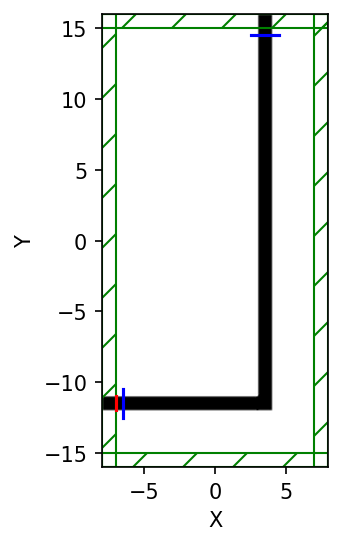

In [9]:
sim.reset_meep()

geometry = [mp.Block(mp.Vector3(sx-pad,w,mp.inf), center=mp.Vector3(-0.5*pad,wvg_ycen), material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(w,sy-pad,mp.inf), center=mp.Vector3(wvg_xcen,0.5*pad), material=mp.Medium(epsilon=12))]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(center=mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5,0), size=mp.Vector3(2*w,0,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

With the flux data, we are ready to compute and plot the reflectance and transmittance. The reflectance is the reflected flux divided by the incident flux. We also have to multiply by -1 because all fluxes in Meep are computed in the positive-coordinate direction by default, and we want the flux in the −x direction. The transmittance is the transmitted flux divided by the incident flux. Finally, the scattered loss is simply 1−transmittance−reflectance. The results are plotted in the accompanying figure.

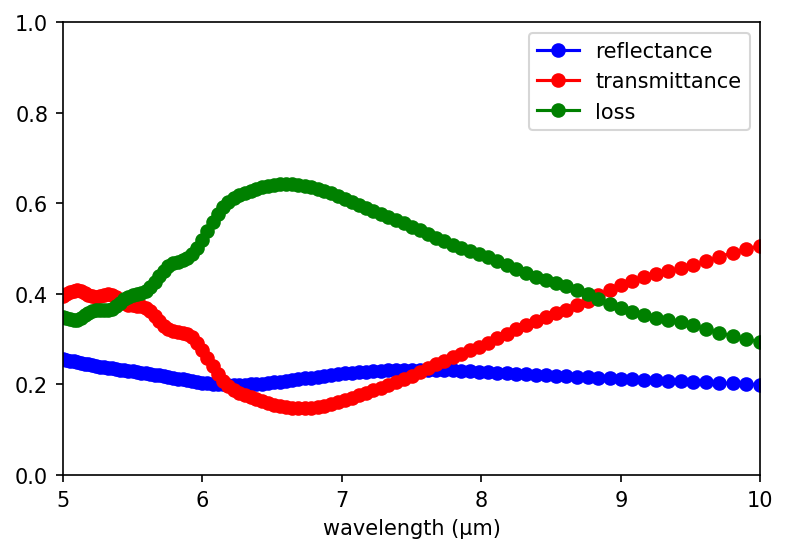

In [10]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-bend_refl_flux[i]/straight_tran_flux[i])
    Ts = np.append(Ts,bend_tran_flux[i]/straight_tran_flux[i])    

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl,Rs,'bo-',label='reflectance')
    plt.plot(wl,Ts,'ro-',label='transmittance')
    plt.plot(wl,1-Rs-Ts,'go-',label='loss')
    plt.axis([5.0, 10.0, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()